<a class="anchor" id="0"></a>
### <p style="background-color:yellow; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">0. Table of Contents</p>

1. [Libraries](#1)
1. [Loading Data](#2)
1. [EDA](#3)
1. [Data Preprocessing](#4)
    * [4.1 Cleaning the Corpus](#4.1)
    * [4.2 Stop Words](#4.2)
    * [4.3 Lemmatization](#4.3)
1. [Tokens Visualization](#5)
    * [5.1 Length of Tweets](#5.1)
    * [5.2 Word Cloud](#5.2)
    * [5.3 Frequency of Words](#5.3)
    * [5.4 Unique Words](#5.4)
    * [5.5 N-grams](#5.5)
        * [5.5.1 Uni-gram](#5.5.1)
        * [5.5.2 Bi-gram](#5.5.2)
        * [5.5.3 Tri-gram](#5.5.3)
1. [Modeling](#6)
    * [6.1 Logistic Regression](#6.1)
        * [6.1.1 Bag-of-Words](#6.1.1)
        * [6.1.2 TF-IDF](#6.1.2)
        * [6.1.3 Evaluation](#6.1.3)
        * [6.1.4 Discussion](#6.1.4)    
    * [6.2 Reccurent Neural Network (BERT Emdedding+LSTM)](#6.2)
        * [6.2.1 Binary Classifier](#6.2.1)
        * [6.2.2 Multi-Class Classifier](#6.2.2)
        * [6.2.3 Linear Classifier](#6.2.3)
        * [6.2.4 Evaluation](#6.2.4)
        * [6.2.5 Discussion](#6.2.5)

Answers to the Research Questions:
* [Q1. What are the accuracy/f1/recall/precision of your model on the Sentiment140 dataset? And on the Dublin dataset?](#Q1)  
* [Q2. Are they or are they not the same? How large is the difference? Can you think of the cause? How would you corroborate or refute your hypothesis?](#Q2)
* [Q3. What are the main classification challenges? (you can find an idea with our suggested approach here, but feel free to do it at your own discretion).](#Q3)
* [Q4. Can you think of a way to measure whether the accuracy is higher for some of the
project categories instead of others, e.g. whether sentiment classification accuracy is higher for the Public Spaces category than for Community and Culture? (see the
dataset schema for details on the categories.) (1-2 paragraphs for each idea is
enough; examples and/or pseudocode would be highly appreciated, too :)](#Q4)
* [Q5. Can you think of any way to measure whether the metrics are higher for documents containing specific types of entities, e.g. Person vs. Location? (Same as above.)](#Q5)
* [Q6. Can you make a proposal to address any/all the issues you have encountered in the
evaluation? (Same as above.)](#Q6)
* [Q7. Can you bring any idea of new feature to develop at Citibeats for Social
Understanding after working on this home assignment?](#Q7)

<a class="anchor" id="1"></a>
### <p style="background-color:yellow; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">1. Libraries</p>
[Back to Table of Contents](#0)

In [1]:
import pandas as pd
import numpy as np
import gc, re, string, random
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
from absl import flags
sys.argv=['preserve_unused_tokens=False']
flags.FLAGS(sys.argv)

['preserve_unused_tokens=False']

In [3]:
from keras.layers import Dense, Input, Dropout
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import os
import spacy
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
%%time
import tensorflow_hub as hub
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)

CPU times: user 12.5 s, sys: 2.9 s, total: 15.4 s
Wall time: 29.5 s


In [5]:
%%time
%%capture
!pip install bert
!pip install tokenization
!pip install transformers==2.4.1
#!pip install tensorflow-gpu

CPU times: user 202 ms, sys: 36.2 ms, total: 238 ms
Wall time: 28.6 s


In [6]:
%%time
%%capture
!python3 -m nltk.downloader wordnet
!unzip ../../usr/share/nltk_data/corpora/wordnet.zip -d ../../usr/share/nltk_data/corpora/

CPU times: user 20.5 ms, sys: 1.65 ms, total: 22.2 ms
Wall time: 2.12 s


In [7]:
#import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import defaultdict

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
import tokenization
import tensorflow as tf
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score)

In [8]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

<a class="anchor" id="2"></a>
### <p style="background-color:yellow; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">2. Loading Data</p>
[Back to Table of Contents](#0)

* train: load only 2% of the data
* test : load all the dataset (get rid of tweets with neutral sentiments)
* dublin test: load all the dataset (get rid of tweets with neutral sentiments)

In [9]:
from google.colab import drive
drive.mount("../Datasets_Colab/")

Mounted at ../Datasets_Colab/


In [10]:
colnames = ["sentiment", "id", "date", "query", "username", "text"]
p = 0.02 # randomly select a subsample of p% of the data (0.1 means 10%)
train = pd.read_csv("/Datasets_Colab/MyDrive/Datasets_Colab/citibeats/data/Sentiment140-train.csv", encoding = "ISO-8859-1", names=colnames, header=None,
                    skiprows=lambda i: i>0 and random.random() > p
                   )
train = train[["text", "sentiment"]]
train['sentiment'] = train['sentiment'].replace({0:"negative", 2:"neutral", 4:"positive"})

In [11]:
test  = pd.read_csv("/Datasets_Colab/MyDrive/Datasets_Colab/citibeats/data/Sentiment140-test.csv", encoding = "ISO-8859-1", names=colnames, header=None)
test = test[["text", "sentiment"]]
test['sentiment'] = test['sentiment'].replace({0:"negative", 2:"neutral", 4:"positive"})

In [12]:
dublin_test = pd.read_csv("/Datasets_Colab/MyDrive/Datasets_Colab/citibeats/data/citypulse.dublin_city_council.test.csv", engine='python')
dublin_test = dublin_test[["text", "sentiment", "category"]]

In [13]:
#  remove neutrals
test = test[test.sentiment !="neutral"]
dublin_test = dublin_test[dublin_test.sentiment !="neutral"]

<a class="anchor" id="3"></a>
### <p style="background-color:yellow; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">3. Exploratory Data Analysis</p>
[Back to Table of Contents](#0)

To get some insights, lets visualize our datasets:

In [14]:
dublin_test.tail(2)

,text,sentiment,category
1998,@KlausBondam @DubCityCouncil Not in the slight...,negative,Infrastructure
1999,Also another thing that Dublin seems to be fuc...,negative,Mobility


In [15]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples') # No neutral sentiments!

,sentiment,text
1,positive,16070
0,negative,15914


In [16]:
temp = test.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,positive,182
0,negative,177


In [17]:
temp = dublin_test.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples') # No neutral sentiments!

,sentiment,text
0,negative,1000
1,positive,1000


* training data has no neutral sentiments!
* datasets are balanced.

<a class="anchor" id="4"></a>
### <p style="background-color:yellow; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">4. Data Preprocessing</p>
[Back to Table of Contents](#0)

<a class="anchor" id="4.1"></a>
### <p style="background-color:yellow; margin: 0px 200px; font-family:newtimeroman; font-size:90%; text-align:center; border-radius: 15px 50px;">4.1 Cleaning the Corpus</p>

Now, before we dive into extracting information from words in text, let's first clean the data:
* replace emojis by using a pre-defined dictionary containing emojis along with their meaning. (eg: ":)" to "EMOJIsmile")
* make text lowercase
* remove text in square brackets
* remove links
* remove punctuation
* remove words containing numbers.
* remove stopwords
* replace 3 or more consecutive letters are replaced by 1 letter. (eg: "Heyyyy" to "Hey")
* lemmatization (converting a word to its base form, e.g: “Great” to “Good”. In the bsaeline model, the meaning of words is not important. Therefore, we can use stemming instead of lemmatization. However, the word meaning is important in the second model. So, we are going to use lemmatization in this study.

In [18]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [19]:
### correct words wrongly written before plotting!
def clean_text(text):
    # Replace all emojis.
    for emoji in emojis.keys(): #in each of the looped tweet, replace each emojis with their respective meaning
        text = text.replace(emoji, "EMOJI" + emojis[emoji])
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub(r'\w*@\w*', '', text) #
    text = re.sub('[%s]' % re.escape('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"(.)\1\1+", r"\1", text) # e.g Replace Heyyyyyyy with Hey
    return text

train['text']        = train['text'].apply(lambda x:clean_text(x))
test['text']         = test['text'].apply(lambda x:clean_text(x))
dublin_test['text']  = dublin_test['text'].apply(lambda x:clean_text(x))

In [20]:
train.duplicated().sum(), test.duplicated().sum(), dublin_test.duplicated().sum()

(411, 0, 83)

In [21]:
train.drop_duplicates(inplace=True), dublin_test.drop_duplicates(inplace=True)
gc.collect()

34

In [22]:
# create a corpus
train['text']       = train['text'].apply(lambda x:str(x).split())
test['text']        = test['text'].apply(lambda x:str(x).split())
dublin_test['text'] = dublin_test['text'].apply(lambda x:str(x).split())

<a class="anchor" id="4.2"></a>
### <p style="background-color:yellow; margin: 0px 200px; font-family:newtimeroman; font-size:90%; text-align:center; border-radius: 15px 50px;">4.2 Stop Words</p>

In [23]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
train['text']       = train['text'].apply(lambda x:remove_stopword(x))
test['text']        = test['text'].apply(lambda x:remove_stopword(x))
dublin_test['text'] = dublin_test['text'].apply(lambda x:remove_stopword(x))

In [24]:
train["text"]       = train["text"].apply(' '.join)
test["text"]        = test["text"].apply(' '.join)
dublin_test["text"] = dublin_test["text"].apply(' '.join)

In [25]:
train.duplicated().sum(), test.duplicated().sum(), dublin_test.duplicated().sum()

(423, 0, 0)

In [26]:
train.drop_duplicates(inplace=True), dublin_test.drop_duplicates(inplace=True)
gc.collect()

0

In [27]:
train['text']       = train['text'].apply(lambda x:str(x).split())
test['text']        = test['text'].apply(lambda x:str(x).split())
dublin_test['text'] = dublin_test['text'].apply(lambda x:str(x).split())

<a class="anchor" id="4.3"></a>
### <p style="background-color:yellow; margin: 0px 200px; font-family:newtimeroman; font-size:90%; text-align:center; border-radius: 15px 50px;">4.3 Lemmatization</p>

In [28]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    #words = text.split()
    words = [lemmatizer.lemmatize(word,pos='v') for word in text]
    return words
train['text']       = train['text'].apply(lemmatize_words)
test['text']        = test['text'].apply(lemmatize_words)
dublin_test['text'] = dublin_test['text'].apply(lemmatize_words)

<a class="anchor" id="5"></a>
### <p style="background-color:yellow; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">5. Tokens Vizualisation</p>
[Back to Table of Contents](#0)

<a class="anchor" id="5.1"></a>
### <p style="background-color:yellow; margin: 0px 200px; font-family:newtimeroman; font-size:90%; text-align:center; border-radius: 15px 50px;">5.1 Length of Tweets</p>

In [29]:
def length(text):
    return len(text)

train["length"]= train.text.apply(length)
test["length"]= test.text.apply(length)
dublin_test["length"]= dublin_test.text.apply(length)

In [30]:
# function to draw histogram
def draw_hist(dataset, xlabel, ylabel,title,target,sub,color):
    plt.subplot(1,2,sub)
    plt.hist(dataset[dataset.sentiment==target]["length"],color = color)
    plt.title(title,fontsize=25)
    plt.xlabel(xlabel,fontsize=15)
    plt.ylabel(ylabel,fontsize=15)
    #plt.ylim(0,1000)
    plt.grid()

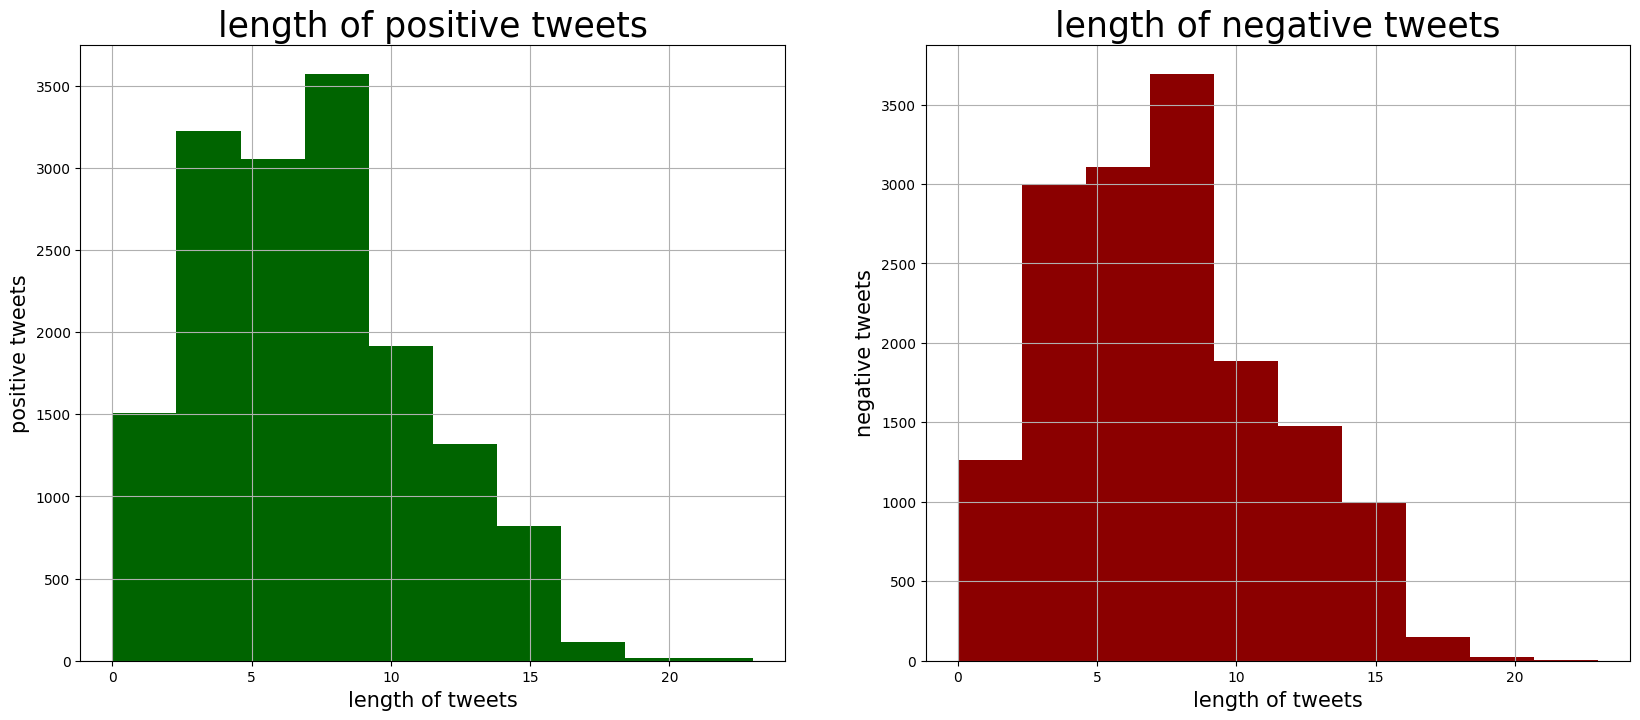

In [31]:
plt.figure(figsize = (20,8))
draw_hist(train, "length of tweets","positive tweets","length of positive tweets", "positive", 1,"darkgreen")
draw_hist(train, "length of tweets","negative tweets","length of negative tweets", "negative", 2,"darkred")

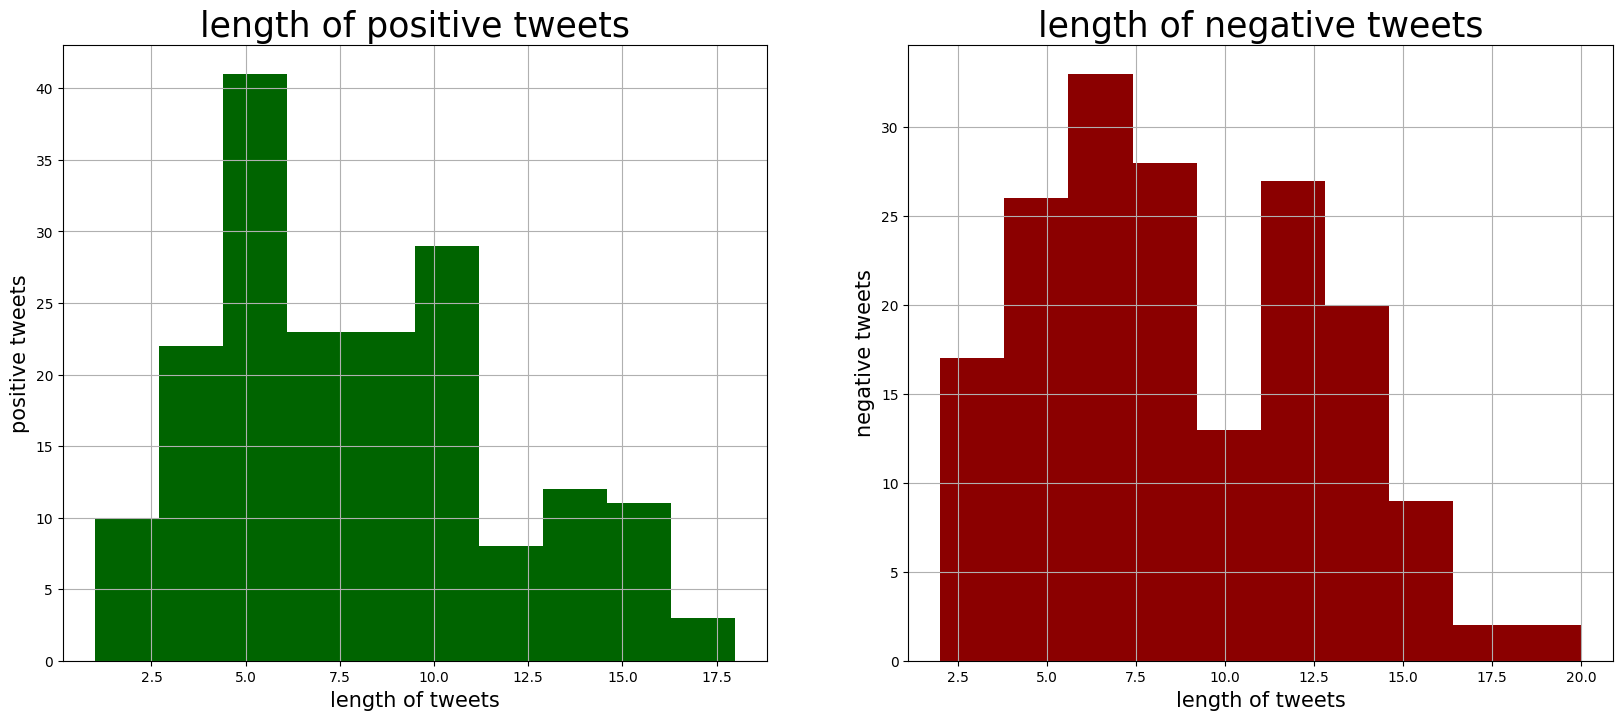

In [32]:
plt.figure(figsize = (20,8))
draw_hist(test, "length of tweets","positive tweets","length of positive tweets", "positive", 1,"darkgreen")
draw_hist(test, "length of tweets","negative tweets","length of negative tweets", "negative", 2,"darkred")

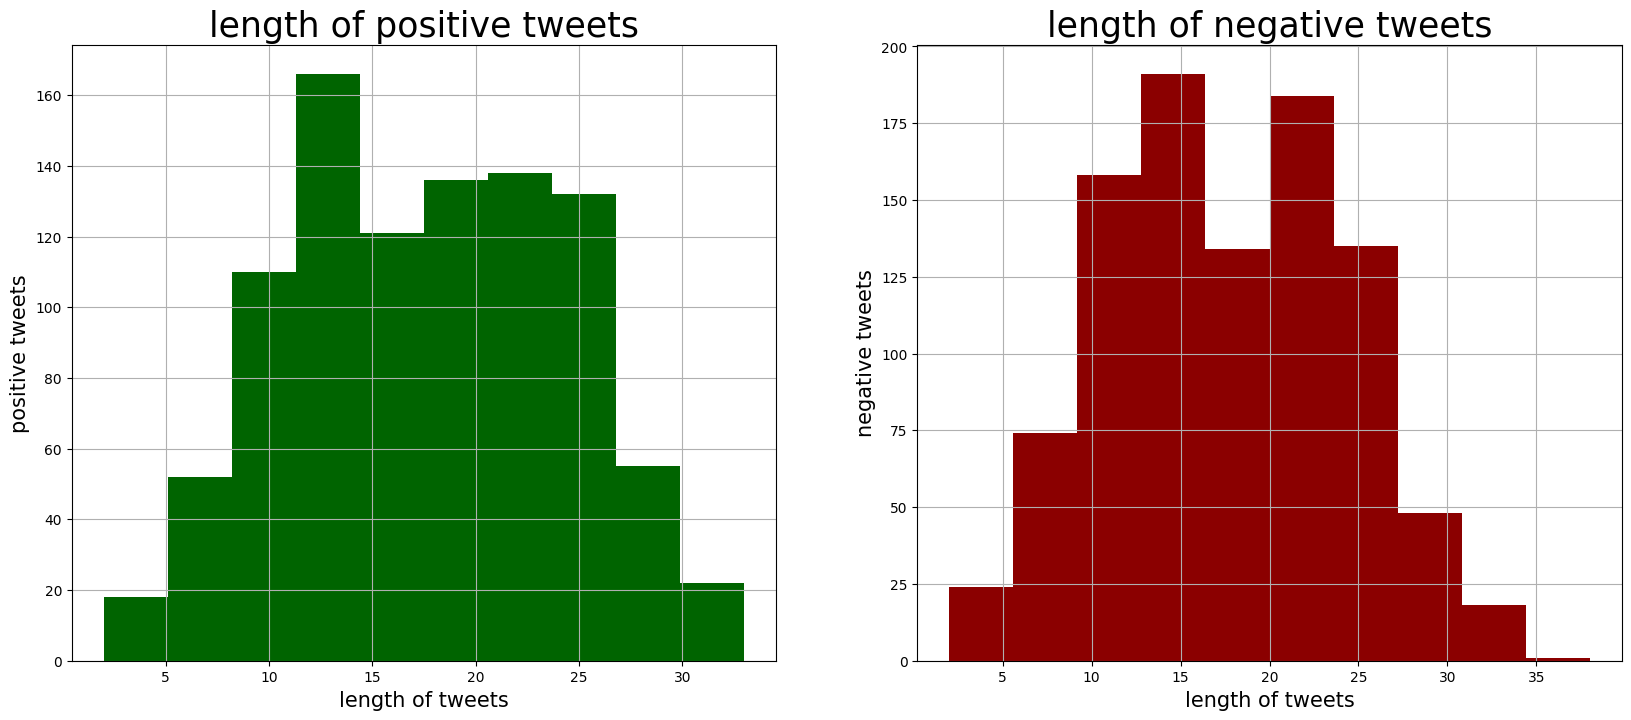

In [33]:
plt.figure(figsize = (20,8))
draw_hist(dublin_test, "length of tweets","positive tweets","length of positive tweets", "positive", 1,"darkgreen")
draw_hist(dublin_test, "length of tweets","negative tweets","length of negative tweets", "negative", 2,"darkred")

The Figure shows that length of positive as well as negative tweets varies in the same range 0 to 30 approx

<a class="anchor" id="5.2"></a>
### <p style="background-color:yellow; margin: 0px 200px; font-family:newtimeroman; font-size:90%; text-align:center; border-radius: 15px 50px;">5.2 Word Cloud</p>

In [34]:
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0),
                   title = None, title_size=40, image_color=False):

    wordcloud = WordCloud(background_color='white',width = 800, height = 300,
                    max_words = max_words,
                    mask = mask)
    wordcloud.generate(text)

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green',
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

d = './'

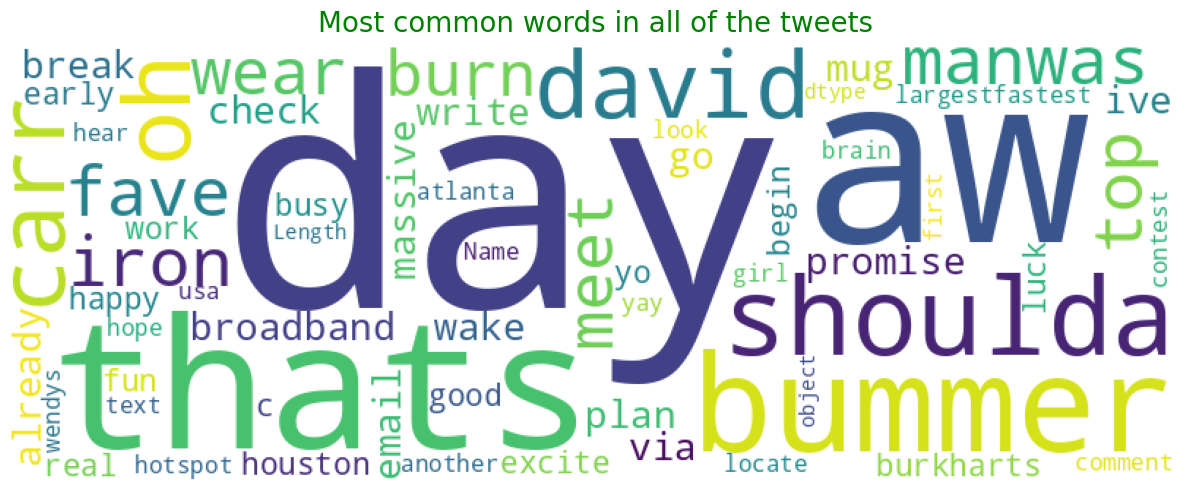

In [35]:
tweet_text = str(train.text)
plot_wordcloud(tweet_text,  max_words=200, max_font_size=40, figure_size=(12,12),
               title = 'Most common words in all of the tweets', title_size=20)

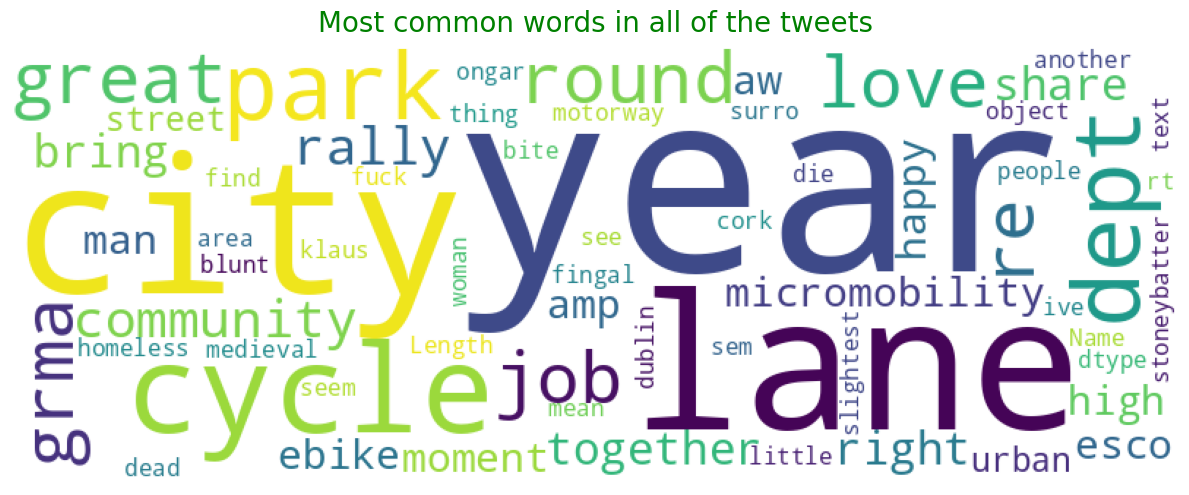

In [36]:
tweet_text = str(dublin_test.text)
plot_wordcloud(tweet_text,  max_words=200, max_font_size=40, figure_size=(12,12),
               title = 'Most common words in all of the tweets', title_size=20)

<a class="anchor" id="5.3"></a>
### <p style="background-color:yellow; margin: 0px 200px; font-family:newtimeroman; font-size:90%; text-align:center; border-radius: 15px 50px;">5.3 Frequency of Words</p>

We can sort those words by frequency and we take the top 20 common words:

In [37]:
from collections import Counter
temp_list = train['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in temp_list for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']

In [38]:
import plotly.express as px
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in the tweets', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [39]:
temp_list = dublin_test['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in temp_list for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']

In [40]:
import plotly.express as px
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in the tweets', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

As depicted in the Figure, most of the common words represents sentiments (positive: like, good, love... or negative: can't, don't...). Now, lets separate those words by sentiments.

***Most common words by sentiments:***

In [41]:
Positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']

In [42]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['text'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,get,1477
1,im,1462
2,go,1315
3,good,1238
4,love,1089
5,thank,891
6,day,860
7,like,828
8,time,668
9,lol,643


In [43]:
#most common negative words
top = Counter([item for sublist in Negative_sent['text'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,go,1889
2,get,1827
3,work,1129
4,miss,935
5,dont,902
6,like,856
7,cant,834
8,want,818
9,feel,743
10,today,728


***Notes:***
* Indeed positive words are more frequent in positive tweets and negative words show-up more in negative tweets.
* We can see words like day, get, go, back, one, today are common in both segments.
* That's interesting because those words are neutral and we can find them in both positive and negative tweets.  
* It will be interesting to see the word unique to different sentiments
* the word like appears in the negative tweets which seems weird. However, we may find sentences like "I don't like..." or "I don't usually like..." in negative tweets. For this reason, we need to use bi gram and 3-gram when applying bag-of-words vectorizer.

<a class="anchor" id="5.4"></a>
### <p style="background-color:yellow; margin: 0px 200px; font-family:newtimeroman; font-size:90%; text-align:center; border-radius: 15px 50px;">5.4 Unique Words</p>

Let's take a look at **unique words** in each segment:

In [44]:
#unique words in each segment
raw_text = [word for word_list in train['text'] for word in word_list]

In [45]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (positive or negative);
        numwords - how many specific words do we want to see in the final result;
        raw_words - list for item in train[train.segments == segments]['text']:
    Output:
        dataframe giving information about the name of the specific word and how many times it show-up in the tweets (in descending order based on their counts)..

    '''
    allother = []
    for item in train[train.sentiment != sentiment]['text']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))

    specificnonly = [x for x in raw_text if x not in allother]

    mycounter = Counter()

    for item in train[train.sentiment == sentiment]['text']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)

    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]

    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])

    return Unique_words

In [46]:
# positive tweets
Unique_Positive = words_unique('positive', 10, raw_text)
print("The top 10 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 10 unique words in Positive Tweets are:


,words,count
0,pleasure,20
1,tweeters,15
2,hee,13
3,musicmonday,12
4,hugh,11
5,delongeday,11
6,username,10
7,giggle,10
8,happier,10
9,subscribe,9


In [47]:
Unique_Negative= words_unique('negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


,words,count
0,migraine,13
1,noes,12
2,infection,11
3,painful,11
4,texted,9
5,allergies,9
6,pills,9
7,sickness,9
8,affect,9
9,wrist,9


***Notes:***

By taking a look at the **unique words** of each sentiment, we now have much more clarity about the data: These unique words are very strong determiners of Sentiment of tweets.

<a class="anchor" id="5.5"></a>
### <p style="background-color:yellow; margin: 0px 200px; font-family:newtimeroman; font-size:90%; text-align:center; border-radius: 15px 50px;">5.5 N-grams</p>

In [48]:
train["text"]       = train["text"].apply(' '.join)
test["text"]        = test["text"].apply(' '.join)
dublin_test["text"] = dublin_test["text"].apply(' '.join)

In [49]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 15

# Unigrams
positive_unigrams = defaultdict(int)
negative_unigrams = defaultdict(int)

for tweet in train[train.sentiment=="positive"]["text"]:
    for word in generate_ngrams(tweet):
        positive_unigrams[word] += 1

for tweet in train[train.sentiment=="negative"]["text"]:
    for word in generate_ngrams(tweet):
        negative_unigrams[word] += 1

df_positive_unigrams = pd.DataFrame(sorted(positive_unigrams.items(), key=lambda x: x[1])[::-1])
df_negative_unigrams = pd.DataFrame(sorted(negative_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
positive_bigrams = defaultdict(int)
negative_bigrams = defaultdict(int)

for tweet in train[train.sentiment=="positive"]["text"]:
    for word in generate_ngrams(tweet, n_gram=2):
        positive_bigrams[word] += 1

for tweet in train[train.sentiment=="negative"]["text"]:
    for word in generate_ngrams(tweet, n_gram=2):
        negative_bigrams[word] += 1

df_positive_bigrams = pd.DataFrame(sorted(positive_bigrams.items(), key=lambda x: x[1])[::-1])
df_negative_bigrams = pd.DataFrame(sorted(negative_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
positive_trigrams = defaultdict(int)
negative_trigrams = defaultdict(int)

for tweet in train[train.sentiment=="positive"]["text"]:
    for word in generate_ngrams(tweet, n_gram=3):
        positive_trigrams[word] += 1

for tweet in train[train.sentiment=="negative"]["text"]:
    for word in generate_ngrams(tweet, n_gram=3):
        negative_trigrams[word] += 1

df_positive_trigrams = pd.DataFrame(sorted(positive_trigrams.items(), key=lambda x: x[1])[::-1])
df_negative_trigrams = pd.DataFrame(sorted(negative_trigrams.items(), key=lambda x: x[1])[::-1])

<a class="anchor" id="5.1.1"></a>
#### ***5.5.1 Uni-gram:***

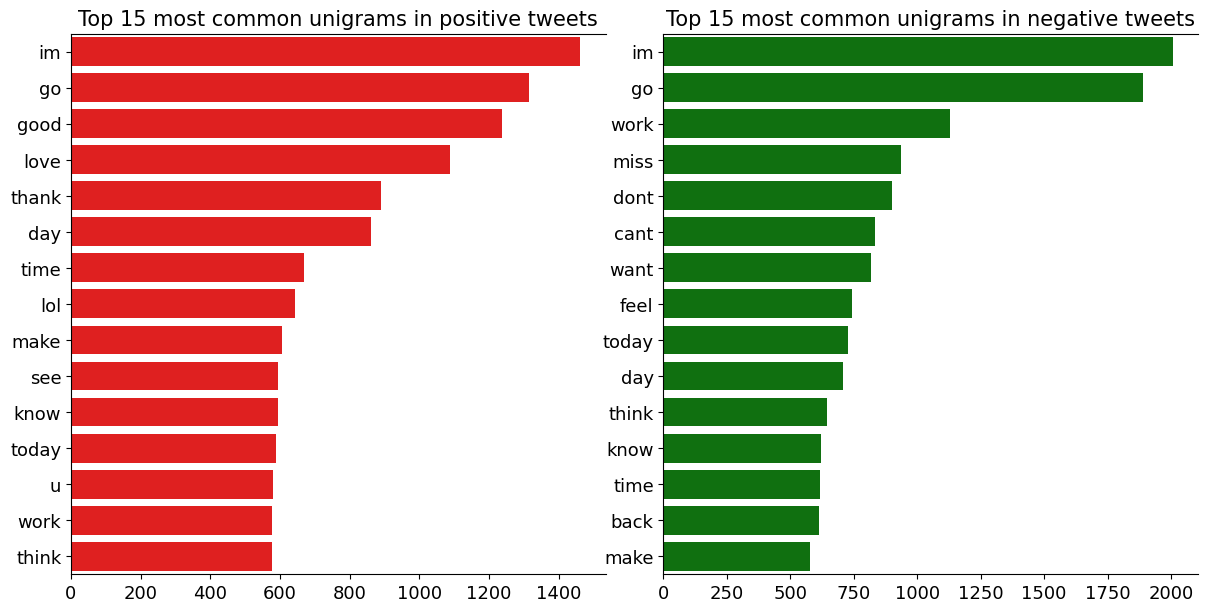

In [50]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6), dpi=100)
plt.tight_layout()

sns.barplot(y=df_positive_unigrams[0].values[:N], x=df_positive_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_negative_unigrams[0].values[:N], x=df_negative_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in positive tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in negative tweets', fontsize=15)

plt.show()

<a class="anchor" id="5.5.2"></a>
#### ***5.5.2 Bi-gram:***

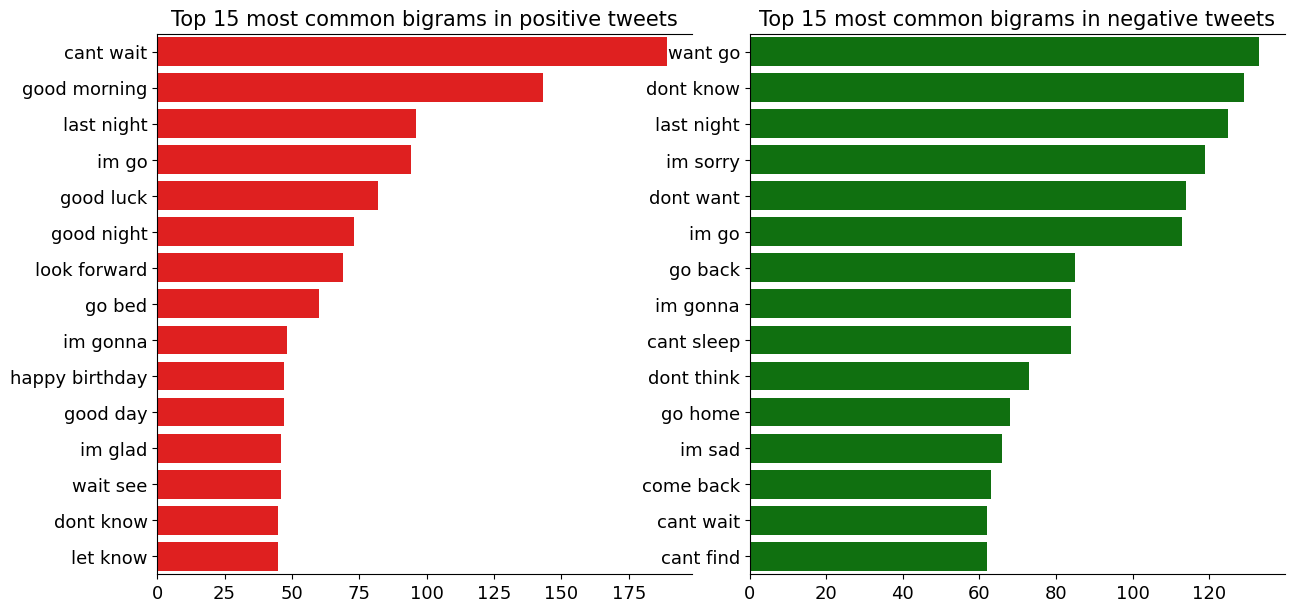

In [51]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6), dpi=100)
plt.tight_layout()

sns.barplot(y=df_positive_bigrams[0].values[:N], x=df_positive_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_negative_bigrams[0].values[:N], x=df_negative_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in positive tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in negative tweets', fontsize=15)

plt.show()

<a class="anchor" id="5.5.3"></a>
#### ***5.5.3 Tri-gram:***

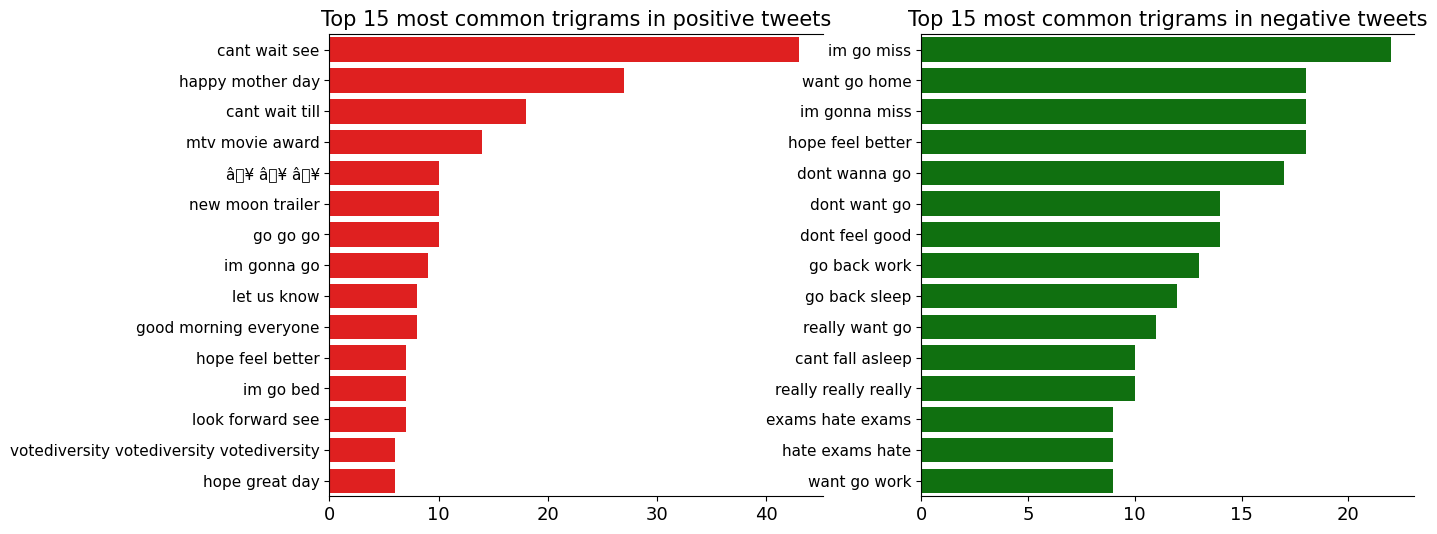

In [52]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6), dpi=100)

sns.barplot(y=df_positive_trigrams[0].values[:N], x=df_positive_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_negative_trigrams[0].values[:N], x=df_negative_trigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in positive tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in negative tweets', fontsize=15)

plt.show()

<a class="anchor" id="6"></a>
### <p style="background-color:yellow; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">6. Modeling</p>
[Back to Table of Contents](#0)

<a class="anchor" id="6.1"></a>
### <p style="background-color:yellow; margin: 0px 200px; font-family:newtimeroman; font-size:90%; text-align:center; border-radius: 15px 50px;">6.1 Logistic Regression</p>

So far, we have the tweets as lists of tokens and now we need to convert each of those tweets into a vector the ML models can work with. We will do that in the following steps using the bag-of-words model:

* Count how many times does a word occur in each tweet (TF)
* Count its frequecy across all the documents (IDF)
* Normalize the vectors to unit length (bi-grams + L2 regularization)

The first and the second step are done using scikit-learn library.

In [53]:
dublin_test.head()

,text,sentiment,category,length
0,park dept great job year round grma regularly ...,positive,Public Spaces,16
1,love city community rally together right 👏🏽👏🏽👏...,positive,Community and Culture,13
2,bring share micromobility ebike amp escooter s...,positive,Mobility,23
3,aw man moment happy,positive,Mobility,4
4,high street lane urban motorway medieval city,positive,Mobility,7


In [54]:
x_train = train['text']
y_train = train['sentiment']
x_test  = test['text']
y_test  = test['sentiment']
x_dublin= dublin_test['text']
y_dublin= dublin_test['sentiment']

<a class="anchor" id="6.1.1"></a>
#### ***6.1.1 Bag-of-Words:***

In [55]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer(ngram_range=(1,3)#, min_df=0.1, max_df=0.7, max_features=100
                      )
vect.fit(x_train)
# Use the trained to create a document-term matrix from train and test sets
x_train_bow   = vect.transform(x_train)
x_test_bow    = vect.transform(x_test)
x_dublin_bow  = vect.transform(x_dublin)

<a class="anchor" id="6.1.2"></a>
#### ***6.1.2 TF-IDF:***

In [56]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_bow)
x_train_tfidf   = tfidf_transformer.transform(x_train_bow)
x_test_tfidf    = tfidf_transformer.transform(x_test_bow)
x_dublin_tfidf  = tfidf_transformer.transform(x_dublin_bow)
x_train_tfidf

<31150x325974 sparse matrix of type '<class 'numpy.float64'>'
	with 569785 stored elements in Compressed Sparse Row format>

In [57]:
# l2-regularizationn
x_train_l2   = normalize(x_train_bow, axis=0)
x_test_l2    = normalize(x_test_bow, axis=0)
x_dublin_l2  = normalize(x_dublin_bow, axis=0)

In [58]:
def simple_logistic_classify(X_tr, y_tr, X_test, y_test, model_name):
    ### Helper function to train a logistic classifier and score on test data
    m = LogisticRegression().fit(X_tr, y_tr)
    #s = m.score(X_test, y_test)
    #print ('Test accuracy score with', model_name, 'features:', round(s, 3))

    return m

m1 = simple_logistic_classify(x_train_bow, y_train, x_test_bow, y_test, 'bow')
m2 = simple_logistic_classify(x_train_l2, y_train, x_test_l2, y_test, 'l2-normalized')
m3 = simple_logistic_classify(x_train_tfidf, y_train, x_test_tfidf, y_test, 'tf-idf')

In [59]:
y_pred_bow   = m1.predict(x_test_bow)
y_pred_l2    = m2.predict(x_test_l2)
y_pred_tfidf = m3.predict(x_test_tfidf)

<a class="anchor" id="6.1.3"></a>
#### ***6.1.3 Evaluation:***

****Score for test set:****

In [60]:
acc_bow        = accuracy_score(y_test, y_pred_bow)
p_bow          = precision_score(y_test, y_pred_bow, pos_label="positive")
r_bow          = recall_score(y_test, y_pred_bow, pos_label="positive")
f1_bow         = f1_score(y_test, y_pred_bow, pos_label="positive")
acc_l2         = accuracy_score(y_test, y_pred_l2)
p_l2           = precision_score(y_test, y_pred_l2, pos_label="positive")
r_l2           = recall_score(y_test, y_pred_l2, pos_label="positive")
f1_l2          = f1_score(y_test, y_pred_l2, pos_label="positive")
acc_tfidf      = accuracy_score(y_test, y_pred_tfidf)
p_tfidf        = precision_score(y_test, y_pred_tfidf, pos_label="positive")
r_tfidf        = recall_score(y_test, y_pred_tfidf, pos_label="positive")
f1_tfidf       = f1_score(y_test, y_pred_tfidf, pos_label="positive")
print("Accuracy:  bow =", round(acc_bow, 2), ", l2 =", round(acc_l2, 2),", tfidf =", round(acc_tfidf, 2))
print("Precision: bow =", round(p_bow, 2), ", l2 =", round(p_l2, 2),", tfidf =", round(p_tfidf, 2))
print("Recall:    bow =", round(r_bow, 2), ", l2 =", round(r_l2, 2),", tfidf =", round(r_tfidf, 2))
print("F1 score:  bow =", round(f1_bow, 2), ", l2 =", round(f1_l2, 2),", tfidf =", round(f1_tfidf, 2))

Accuracy:  bow = 0.78 , l2 = 0.78 , tfidf = 0.78
Precision: bow = 0.76 , l2 = 0.78 , tfidf = 0.76
Recall:    bow = 0.82 , l2 = 0.79 , tfidf = 0.82
F1 score:  bow = 0.79 , l2 = 0.78 , tfidf = 0.79


****Score for Dublin test set:****

In [61]:
y_D_pred_bow   = m1.predict(x_dublin_bow)
y_D_pred_l2    = m2.predict(x_dublin_l2)
y_D_pred_tfidf = m3.predict(x_dublin_tfidf)

In [62]:
acc_D_bow        = accuracy_score(y_dublin, y_D_pred_bow)
p_D_bow          = precision_score(y_dublin, y_D_pred_bow, pos_label="positive")
r_D_bow          = recall_score(y_dublin, y_D_pred_bow, pos_label="positive")
f1_D_bow         = f1_score(y_dublin, y_D_pred_bow, pos_label="positive")
acc_D_l2         = accuracy_score(y_dublin, y_D_pred_l2)
p_D_l2           = precision_score(y_dublin, y_D_pred_l2, pos_label="positive")
r_D_l2           = recall_score(y_dublin, y_D_pred_l2, pos_label="positive")
f1_D_l2          = f1_score(y_dublin, y_D_pred_l2, pos_label="positive")
acc_D_tfidf      = accuracy_score(y_dublin, y_D_pred_tfidf)
p_D_tfidf        = precision_score(y_dublin, y_D_pred_tfidf, pos_label="positive")
r_D_tfidf        = recall_score(y_dublin, y_D_pred_tfidf, pos_label="positive")
f1_D_tfidf       = f1_score(y_dublin, y_D_pred_tfidf, pos_label="positive")
print("Accuracy:  bow =", round(acc_D_bow, 2), ", l2 =", round(acc_D_l2, 2),", tfidf =", round(acc_D_tfidf, 2))
print("Precision: bow =", round(p_D_bow, 2), ", l2 =", round(p_D_l2, 2),", tfidf =", round(p_D_tfidf, 2))
print("Recall:    bow =", round(r_D_bow, 2), ", l2 =", round(r_D_l2, 2),", tfidf =", round(r_D_tfidf, 2))
print("F1 score:  bow =", round(f1_D_bow, 2), ", l2 =", round(f1_D_l2, 2),", tfidf =", round(f1_D_tfidf, 2))

Accuracy:  bow = 0.66 , l2 = 0.67 , tfidf = 0.67
Precision: bow = 0.65 , l2 = 0.67 , tfidf = 0.66
Recall:    bow = 0.69 , l2 = 0.64 , tfidf = 0.67
F1 score:  bow = 0.67 , l2 = 0.66 , tfidf = 0.66


<a class="anchor" id="6.1.4"></a>
#### ***6.1.4 Discussion:***

<a class="anchor" id="6.2"></a>
### <p style="background-color:yellow; margin: 0px 200px; font-family:newtimeroman; font-size:90%; text-align:center; border-radius: 15px 50px;">6.2 Reccurent Neural Network (BERT Emdedding+LSTM)</p>

In [63]:
%%capture
!pip install transformers
from transformers import logging
logging.set_verbosity_warning()

In [64]:
#############
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Reshape
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, TFBertModel

In [65]:
# label encoding the target
train["sentiment"].replace({'positive':1,'negative':0}, inplace = True)
test["sentiment"].replace({'positive':1,'negative':0}, inplace = True)
dublin_test["sentiment"].replace({'positive':1,'negative':0}, inplace = True)

<a class="anchor" id="6.2.1"></a>
#### ***6.2.1 Binary Classifier:***

In [66]:
# Set your desired parameters
bert_model_name = 'bert-base-uncased'
hidden_size = 128
max_sequence_length = 128

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = TFBertModel.from_pretrained(bert_model_name)

# Function to preprocess the text and convert it into input tensors
def preprocess_text(text_list, tokenizer, max_sequence_length):

    all_tokens = []
    all_masks = []
    all_segments = []

    for text in text_list:
        text = tokenizer.tokenize(text)
        text = text[:max_sequence_length - 2]
        input_sequence = ['[CLS]'] + text + ['[SEP]']
        pad_len = max_sequence_length - len(input_sequence)

        tokens = tokenizer.convert_tokens_to_ids(input_sequence)

        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_sequence_length

        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)


# Build the sentiment analysis model with LSTM on top of BERT outputs
input_ids = Input(shape=(max_sequence_length,), dtype='int32', name='input_ids')
attention_mask = Input(shape=(max_sequence_length,), dtype='int32', name='attention_mask')
segment_ids = Input(shape=(max_sequence_length,), dtype='int32', name='segment_ids')

# Get the BERT embeddings for the input sequence
#bert_output = bert_model(input_ids, attention_mask, segment_ids)[0]
_, sequence_output = bert_layer([input_ids, attention_mask, segment_ids])


# Use the output of the [CLS] token as a summary of the entire sequence
pooled_output = sequence_output[:, 0, :]

lstm_input = Reshape((1, pooled_output.shape[1]))(pooled_output)

# Apply an LSTM layer on top of the BERT embeddings
lstm_output = LSTM(hidden_size)(lstm_input)
lstm_output = Dropout(0.2)(lstm_output)
# Add a fully connected layer for classification
output = Dense(1, activation='sigmoid')(lstm_output)  # Changed to one node with a sigmoid activation function

# Define the model
model = Model(inputs=[input_ids, attention_mask, segment_ids], outputs=output)

# Compile the model with binary_crossentropy for binary classification
optimizer = Adam(lr=1e-5)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print the model summary
model.summary()


# Preprocess the text and convert to input tensors
input_ids_train, attention_mask_train, segment_ids_train = preprocess_text(train['text'], tokenizer, max_sequence_length)
labels_train = np.array(train['sentiment'])

# Train the model
#model.fit((input_ids_train, attention_mask_train, segment_ids_train), labels_train, batch_size=32, epochs=10, validation_split=0.2)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_ids[0][0]',              
                                 (None, 128, 768)]                'attention_mask[0][0]',     

In [67]:
# Preprocess the text and convert to input tensors for the test set
# input_ids_test, attention_mask_test, segment_ids_test = preprocess_text(test['text'], tokenizer, max_sequence_length)

# # Predict the sentiment for the test set
# predictions = model.predict((input_ids_test, attention_mask_test, segment_ids_test))

# # Convert the predicted probabilities to sentiment labels ('positive' or 'negative')
# predicted_sentiments = [1 if p > 0.5 else 0 for p in predictions]


In [68]:
# accuracy_score(y_test, predicted_sentiments)

In [69]:
# # Preprocess the text and convert to input tensors for the Dublin test set
# input_ids_test, attention_mask_test, segment_ids_test = preprocess_text(dublin_test['text'], tokenizer, max_sequence_length)

# # Predict the sentiment for the Dubliin test set
# predictions = model.predict((input_ids_test, attention_mask_test, segment_ids_test))

# # Convert the predicted probabilities to sentiment labels ('positive' or 'negative')
# predicted_sentiments_d = [1 if p > 0.5 else 0 for p in predictions]

<a class="anchor" id="6.2.2"></a>
#### ***6.2.2 Multi-Class Classifier:***

In [70]:
from keras.utils import to_categorical

# Build the sentiment analysis model with LSTM on top of BERT outputs
input_ids = Input(shape=(max_sequence_length,), dtype='int32', name='input_ids')
attention_mask = Input(shape=(max_sequence_length,), dtype='int32', name='attention_mask')
segment_ids = Input(shape=(max_sequence_length,), dtype='int32', name='segment_ids')

# Get the BERT embeddings for the input sequence
#bert_output = bert_model(input_ids, attention_mask, segment_ids)[0]
_, sequence_output = bert_layer([input_ids, attention_mask, segment_ids])


# Use the output of the [CLS] token as a summary of the entire sequence
pooled_output = sequence_output[:, 0, :]

lstm_input = Reshape((1, pooled_output.shape[1]))(pooled_output)

# Apply an LSTM layer on top of the BERT embeddings
lstm_output = LSTM(hidden_size)(lstm_input)
lstm_output = Dropout(0.2)(lstm_output)
# Add a fully connected layer for classification
output = Dense(2, activation='softmax')(lstm_output)  # Changed to one node with a
                                                       # sigmoid activation function

# Define the model
model1 = Model(inputs=[input_ids, attention_mask, segment_ids], outputs=output)

# Compile the model with binary_crossentropy for binary classification
optimizer = Adam(lr=1e-5)
model1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print the model summary
model1.summary()


# Preprocess the text and convert to input tensors
input_ids_train, attention_mask_train, segment_ids_train = preprocess_text(train['text'],
                                                            tokenizer, max_sequence_length)
labels_train = np.array(train['sentiment'])

# Convert binary labels to one-hot encoded format
labels_train = to_categorical(labels_train, num_classes=2)

# Train the model
model1.fit((input_ids_train, attention_mask_train, segment_ids_train),
           labels_train, batch_size=32, epochs=10, validation_split=0.2)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_ids[0][0]',              
                                 (None, 128, 768)]                'attention_mask[0][0]',   

In [71]:
# Preprocess the text in the test set and convert to input tensors
input_ids_test, attention_mask_test, segment_ids_test = preprocess_text(test['text'],
                                                        tokenizer, max_sequence_length)

# Make predictions on the test set
predictions = model1.predict((input_ids_test, attention_mask_test, segment_ids_test))
# Convert the softmax probabilities to class labels (0 or 1)
predicted_m1_test = np.argmax(predictions, axis=1)

12/12 [==============================] - 5s 252ms/step


In [72]:
# Dublin test
input_ids_dublin, attention_mask_dublin, segment_ids_dublin = preprocess_text(dublin_test['text'],
                                                        tokenizer, max_sequence_length)
predictions = model1.predict((input_ids_dublin, attention_mask_dublin, segment_ids_dublin))
predicted_m1_dublin = np.argmax(predictions, axis=1)

60/60 [==============================] - 17s 279ms/step


In [73]:
acc_m1_test       = accuracy_score(y_test, predicted_m1_test)
acc_m1_dublin     = accuracy_score(y_dublin, predicted_m1_dublin)

p_m1_test         = precision_score(y_test, predicted_m1_test, pos_label=1)
p_m1_dublin       = precision_score(y_dublin, predicted_m1_dublin, pos_label=1)

r_m1_test         = recall_score(y_test, predicted_m1_test, pos_label=1)
r_m1_dublin       = recall_score(y_dublin, predicted_m1_dublin, pos_label=1)

f1_m1_test        = f1_score(y_test, predicted_m1_test, pos_label=1)
f1_m1_dublin      = f1_score(y_dublin, predicted_m1_dublin, pos_label=1)

In [74]:
print("Accuracy:  test =", round(acc_m1_test, 2), ", dublin test=", round(acc_m1_dublin, 2))
print("Precision: test =", round(p_m1_test, 2), ", dublin test=", round(p_m1_dublin, 2))
print("Recall:    test =", round(r_m1_test, 2), ", dublin test=", round(r_m1_dublin, 2))
print("F1 score:  test =", round(f1_m1_test, 2), ", dublin test=", round(f1_m1_dublin, 2))

Accuracy:  test = 0.8 , dublin test= 0.68
Precision: test = 0.84 , dublin test= 0.7
Recall:    test = 0.75 , dublin test= 0.61
F1 score:  test = 0.79 , dublin test= 0.65


<a class="anchor" id="6.2.3"></a>
#### ***6.2.3 Linear Classifier***

In [75]:
# Build the sentiment analysis model with LSTM on top of BERT outputs
input_ids = Input(shape=(max_sequence_length,), dtype='int32', name='input_ids')
attention_mask = Input(shape=(max_sequence_length,), dtype='int32', name='attention_mask')
segment_ids = Input(shape=(max_sequence_length,), dtype='int32', name='segment_ids')

# Get the BERT embeddings for the input sequence
#bert_output = bert_model(input_ids, attention_mask, segment_ids)[0]
_, sequence_output = bert_layer([input_ids, attention_mask, segment_ids])


# Use the output of the [CLS] token as a summary of the entire sequence
pooled_output = sequence_output[:, 0, :]

lstm_input = Reshape((1, pooled_output.shape[1]))(pooled_output)

# Apply an LSTM layer on top of the BERT embeddings
lstm_output = LSTM(hidden_size)(lstm_input)
lstm_output = Dropout(0.2)(lstm_output)

# Add a linear classifier on top of the BERT embeddings
output = Dense(1, activation='linear')(lstm_output)  # Linear activation

# Define the model
model2 = Model(inputs=[input_ids, attention_mask, segment_ids], outputs=output)

# Compile the model with binary_crossentropy for binary classification
optimizer = Adam(lr=1e-5)
model2.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

# Print the model summary
model2.summary()


# Preprocess the text and convert to input tensors
input_ids_train, attention_mask_train, segment_ids_train = preprocess_text(train['text'], tokenizer, max_sequence_length)
labels_train = np.array(train['sentiment'])


# Train the model
model2.fit((input_ids_train, attention_mask_train, segment_ids_train), labels_train, batch_size=32, epochs=10, validation_split=0.2)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_ids[0][0]',              
                                 (None, 128, 768)]                'attention_mask[0][0]',   

In [76]:
# Predict values for the test set
predictions = model2.predict((input_ids_test, attention_mask_test, segment_ids_test))

# Convert predictions to binary values (0 or 1) based on the threshold of 0.5
predicted_m2_test = (predictions >= 0.5).astype(int).flatten()

12/12 [==============================] - 5s 249ms/step


In [77]:
# Dublin set
predictions = model2.predict((input_ids_dublin, attention_mask_dublin, segment_ids_dublin))
predicted_m2_dublin = (predictions >= 0.5).astype(int).flatten()

60/60 [==============================] - 16s 277ms/step


In [78]:
len(predicted_m2_test)

359

In [79]:
acc_m2_test       = accuracy_score(y_test, predicted_m2_test)
acc_m2_dublin     = accuracy_score(y_dublin, predicted_m2_dublin)

p_m2_test         = precision_score(y_test, predicted_m2_test, pos_label=1)
p_m2_dublin       = precision_score(y_dublin, predicted_m2_dublin, pos_label=1)

r_m2_test         = recall_score(y_test, predicted_m2_test, pos_label=1)
r_m2_dublin       = recall_score(y_dublin, predicted_m2_dublin, pos_label=1)

f1_m2_test        = f1_score(y_test, predicted_m2_test, pos_label=1)
f1_m2_dublin      = f1_score(y_dublin, predicted_m2_dublin, pos_label=1)

In [80]:
print("Accuracy:  test =", round(acc_m2_test, 2), ", dublin test=", round(acc_m2_dublin, 2))
print("Precision: test =", round(p_m2_test, 2), ", dublin test=", round(p_m2_dublin, 2))
print("Recall:    test =", round(r_m2_test, 2), ", dublin test=", round(r_m2_dublin, 2))
print("F1 score:  test =", round(f1_m2_test, 2), ", dublin test=", round(f1_m2_dublin, 2))

Accuracy:  test = 0.78 , dublin test= 0.63
Precision: test = 0.92 , dublin test= 0.79
Recall:    test = 0.62 , dublin test= 0.35
F1 score:  test = 0.74 , dublin test= 0.48


<a class="anchor" id="6.2.4"></a>
#### ***6.2.4 Evaluation:***

<a class="anchor" id="6.2.5"></a>
#### ***6.2.5 Discussion:***

In [81]:
stooooooooop

NameError: ignored